<a href="https://colab.research.google.com/github/SanthushiPrabodha/App-Insighter-Project/blob/main/Copy_of_EmotionDetection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])
  ))

Saving archive.zip to archive.zip
User uploaded file "archive.zip" with length 63252113 bytes


In [5]:
from zipfile import ZipFile
file_name = "archive.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [6]:
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_dir = 'train'
val_dir = 'test'
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (48,48),
    batch_size = 64,
    color_mode = "grayscale",
    class_mode = 'categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(48,48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical"
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
emotion_model = Sequential()
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))
emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

In [9]:
emotion_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


448/448 [==============================] - 30s 44ms/step - loss: 1.8074 - accuracy: 0.2563 - val_loss: 1.7293 - val_accuracy: 0.3122
Epoch 2/50
448/448 [==============================] - 19s 42ms/step - loss: 1.6430 - accuracy: 0.3607 - val_loss: 1.5458 - val_accuracy: 0.4149
Epoch 3/50
448/448 [==============================] - 19s 42ms/step - loss: 1.5365 - accuracy: 0.4119 - val_loss: 1.4769 - val_accuracy: 0.4354
Epoch 4/50
448/448 [==============================] - 19s 42ms/step - loss: 1.4656 - accuracy: 0.4398 - val_loss: 1.4166 - val_accuracy: 0.4630
Epoch 5/50
448/448 [==============================] - 19s 42ms/step - loss: 1.4062 - accuracy: 0.4645 - val_loss: 1.3788 - val_accuracy: 0.4701
Epoch 6/50
448/448 [==============================] - 21s 47ms/step - loss: 1.3549 - accuracy: 0.4854 - val_loss: 1.3219 - val_accuracy: 0.4944
Epoch 7/50
448/448 [==============================] - 19s 42ms/step - loss: 1.3095 - accuracy: 0.5017 - val_loss: 1.2845 - val_accuracy: 0.5109
Epo

In [10]:
#Saving the model
emotion_model.save('model.h5')

In [11]:
from tensorflow.keras.models import load_model
emotion_model = load_model('model.h5')

In [20]:
def emotion_analysis(emotions):
  objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
  y_pos = np.arange(len(objects))

  plt.bar(y_pos, emotions, align='center', alpha=0.5)
  plt.xticks(y_pos, objects)
  plt.ylabel('percentage')
  plt.title('emotion')

  plt.show()

In [21]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='capture.jpg', quality=0.8):
  js = Javascript(''' 
      async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [33]:
take_photo()

<IPython.core.display.Javascript object>

'capture.jpg'

'NoneType' object has no attribute 'shape'


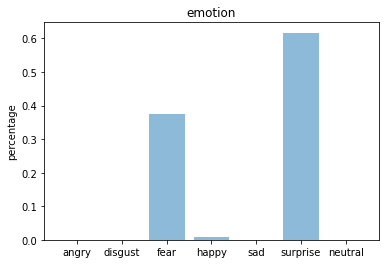

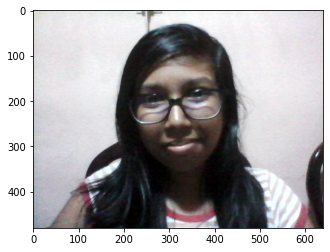

In [34]:
import cv2
            
def facecrop(image):  
    facedata = '/content/haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            
            cv2.imwrite('photo.jpg', sub_face)
            #print ("Writing: " + image)

    except Exception as e:
        print (e)

if __name__ == '__main__':
    facecrop('/content/photo.jpg')

#Testing a file.

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = '/content/capture.jpg'
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = emotion_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

 
plt.imshow(true_image)
plt.show()